In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az
import trace

from sklearn.datasets import make_classification

# числові значення

In [2]:
def bayesian_ab_test_numeric(y0, y1, draws=2000, tune=1000, chains=4, target_accept=0.9):
    """
    Виконує Bayesian A/B тест за допомогою PyMC.

    Аргументи:
        y0: array-like, дані групи A
        y1: array-like, дані групи B
        draws: int, кількість семплів з постеріорного розподілу (чим більше, тим точніше оцінки)
        tune: int, кількість ітерацій розігріву (адаптація кроків MCMC, не враховується у фінальних семплах)
        chains: int, кількість незалежних MCMC ланцюжків (для перевірки збігу)
        target_accept: float, цільова ймовірність прийняття кроку в NUTS 
                    (більше значення = стабільніше, але повільніше)

    Особливості:
        - Можливість враховувати попередні знання або історичні дані через апріорні розподіли.
        У коді це реалізовано через:
            mu0 = pm.Normal("mu0", mu=np.mean(y0), sigma=10 * np.std(y0))  # апріор середнього A
            mu1 = pm.Normal("mu1", mu=np.mean(y1), sigma=10 * np.std(y1))  # апріор середнього B
            sigma0 = pm.HalfNormal("sigma0", sigma=np.std(y0))             # апріор стандартного відхилення A
            sigma1 = pm.HalfNormal("sigma1", sigma=np.std(y1))             # апріор стандартного відхилення B
        Зміна цих значень дозволяє врахувати експертну думку або історичні дані.
        Наприклад:
            mu0 = pm.Normal("mu0", mu=50, sigma=5)
            mu1 = pm.Normal("mu1", mu=52)
            sigma0 = pm.HalfNormal("sigma0", sigma=2)
            sigma1 = pm.HalfNormal("sigma1", sigma=2)

        - Вибір апріорного розподілу (Normal, HalfNormal, Beta тощо) критично впливає на результати, особливо при невеликій кількості даних.

        - Постеріорний розподіл delta:
            delta = pm.Deterministic("delta", mu1 - mu0)
        показує ймовірність того, що варіант B кращий за A.

    Повертає:
        delta_samples: array, семпли постеріору різниці середніх (mu1 - mu0)
        trace: arviz.InferenceData, повний об’єкт MCMC для подальшого аналізу та візуалізації
    """

    y_combined = np.concatenate([y0, y1])
    mu_mean = np.mean(y_combined)
    mu_std = np.std(y_combined)

    with pm.Model() as model:

        mu0 = pm.Normal("mu0", mu=mu_mean, sigma=10 * mu_std)
        mu1 = pm.Normal("mu1", mu=mu_mean, sigma=10 * mu_std)

        sigma0 = pm.HalfNormal("sigma0", sigma=mu_std)
        sigma1 = pm.HalfNormal("sigma1", sigma=mu_std)

        pm.Normal("likelihood0", mu=mu0, sigma=sigma0, observed=y0)
        pm.Normal("likelihood1", mu=mu1, sigma=sigma1, observed=y1)

        pm.Deterministic("delta", mu1 - mu0)

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            return_inferencedata=True,
            progressbar=True
        )

    delta_samples = trace.posterior["delta"].values.flatten()

    pm.plot_posterior(trace,var_names=["mu0", "mu1", "delta"],kind="kde",hdi_prob=0.95)

    return delta_samples, trace

In [3]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

gross_summ = X[:, 0]*50 + np.random.normal(0, 15, size=10000) 
gross_summ += np.where(y==1, 25, 0)

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(gross_summ),
    'target': y
})

df_fake.head()

,user_id,gross_summ,target
0,72,28.887889,0
1,48,10.548666,0
2,192,2.040099,1
3,48,38.615269,0
4,186,48.009842,1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, mu1, sigma0, sigma1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


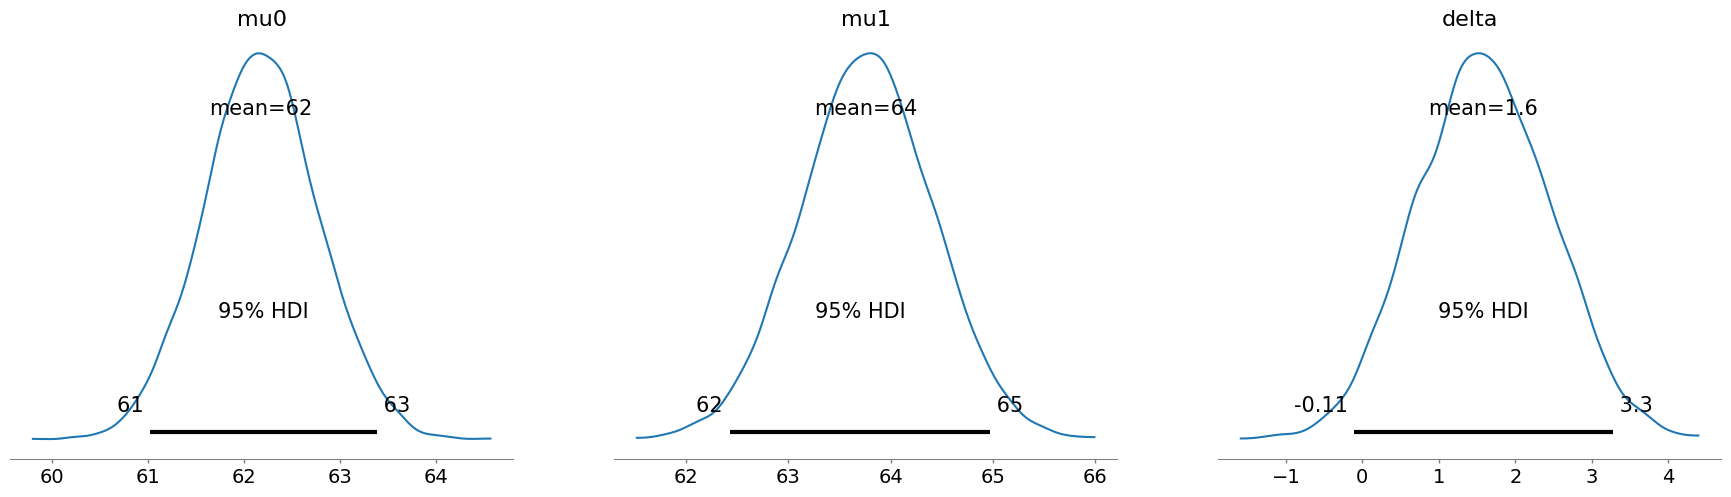

In [4]:
y0 = df_fake[df_fake['target'] == 0]['gross_summ'].values
y1 = df_fake[df_fake['target'] == 1]['gross_summ'].values

delta_samples, trace = bayesian_ab_test_numeric(
    y0=y0,
    y1=y1,
    draws=2000,
    tune=1000,
    chains=4,
    target_accept=0.9,
)

P(delta > 1) = 0.7741


<Axes: ylabel='Density'>

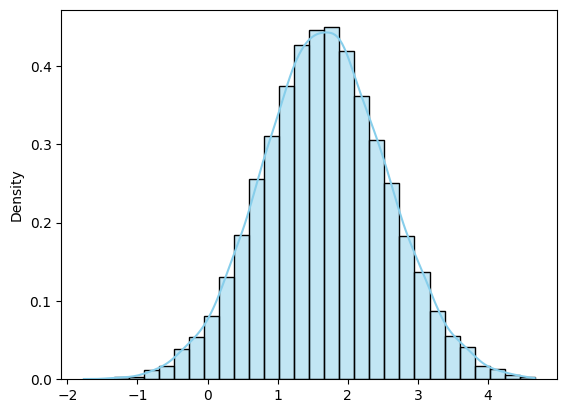

In [5]:
prob_delta_gt_0 = (delta_samples > 1).mean()
print(f"P(delta > 1) = {prob_delta_gt_0:.4f}")

sns.histplot(delta_samples, kde=True, stat="density", bins=30, color="skyblue", edgecolor="black")

Вірогідність мати значення більше (в даному випадку 84% шанс мати значення більше за 1) є площою всіх барів що йдуть праворуч від обраного значення

In [6]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0,61.709,0.614,60.536,62.865,0.007,0.007,8486.0,5978.0,1.0
mu1,63.378,0.653,62.152,64.582,0.007,0.007,9310.0,5818.0,1.0
sigma0,43.414,0.432,42.579,44.204,0.005,0.005,8808.0,5869.0,1.0
sigma1,46.178,0.460,45.323,47.054,0.005,0.005,8221.0,6094.0,1.0
delta,1.669,0.892,0.035,3.393,0.010,0.009,8670.0,6685.0,1.0


# binary

In [8]:
def bayesian_ab_test_binary(y0, y1, draws=2000, tune=1000, chains=4, target_accept=0.9):
    """
    Виконує Bayesian A/B тест для бінарних даних (0/1) за допомогою PyMC.

    Аргументи:
        y0: array-like, бінарні дані групи A (0/1)
        y1: array-like, бінарні дані групи B (0/1)
        draws: int, кількість семплів постеріору (чим більше, тим точніше оцінки)
        tune: int, кількість ітерацій розігріву (адаптація кроків MCMC, не враховується у фінальних семплах)
        chains: int, кількість незалежних MCMC ланцюжків (для перевірки збігу)
        target_accept: float, цільова ймовірність прийняття кроку в NUTS
                    (більше значення = стабільніше, але повільніше)

    Особливості:
        - Можливість враховувати попередні знання через апріорні розподіли для ймовірностей:
            p0 = pm.Beta("p0", alpha=1, beta=1)  # апріор для конверсії групи A
            p1 = pm.Beta("p1", alpha=1, beta=1)  # апріор для конверсії групи B
        Зміна alpha і beta дозволяє врахувати історичні дані або експертну думку. 
        Наприклад, якщо попередні дані показують ~30% конверсії у групі A:
            p0 = pm.Beta("p0", alpha=30, beta=70)
        
        - Вибір розподілу (тут Beta для ймовірностей) критично впливає на результати, особливо при невеликій кількості спостережень.

        - Постеріорний розподіл delta:
            delta = pm.Deterministic("delta", p1 - p0)
        показує ймовірність того, що варіант B кращий за A (p1 > p0).

    Повертає:
        delta_samples: array, семпли постеріору різниці конверсій (p1 - p0)
        trace: arviz.InferenceData, повний об’єкт MCMC для аналізу та візуалізації
    """

    with pm.Model() as model:
        p0 = pm.Beta("p0", alpha=1, beta=1)
        p1 = pm.Beta("p1", alpha=1, beta=1)

        pm.Binomial("likelihood0", n=1, p=p0, observed=y0)
        pm.Binomial("likelihood1", n=1, p=p1, observed=y1)

        pm.Deterministic("delta", p1 - p0)

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            return_inferencedata=True,
            progressbar=True
        )

    delta_samples = trace.posterior["delta"].values.flatten()

    pm.plot_posterior(trace,var_names=["p0", "p1", "delta"],kind="kde",hdi_prob=0.95)

    return delta_samples, trace

In [9]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

conversion = np.zeros(10000, dtype=int)
conversion[y == 0] = np.random.binomial(1, 0.3, size=(y==0).sum())
conversion[y == 1] = np.random.binomial(1, 0.32, size=(y==1).sum())

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'conversion': conversion,
    'target': y
})

df_fake.head()

,user_id,conversion,target
0,115,0,0
1,6,0,1
2,112,1,0
3,108,1,0
4,7,0,0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


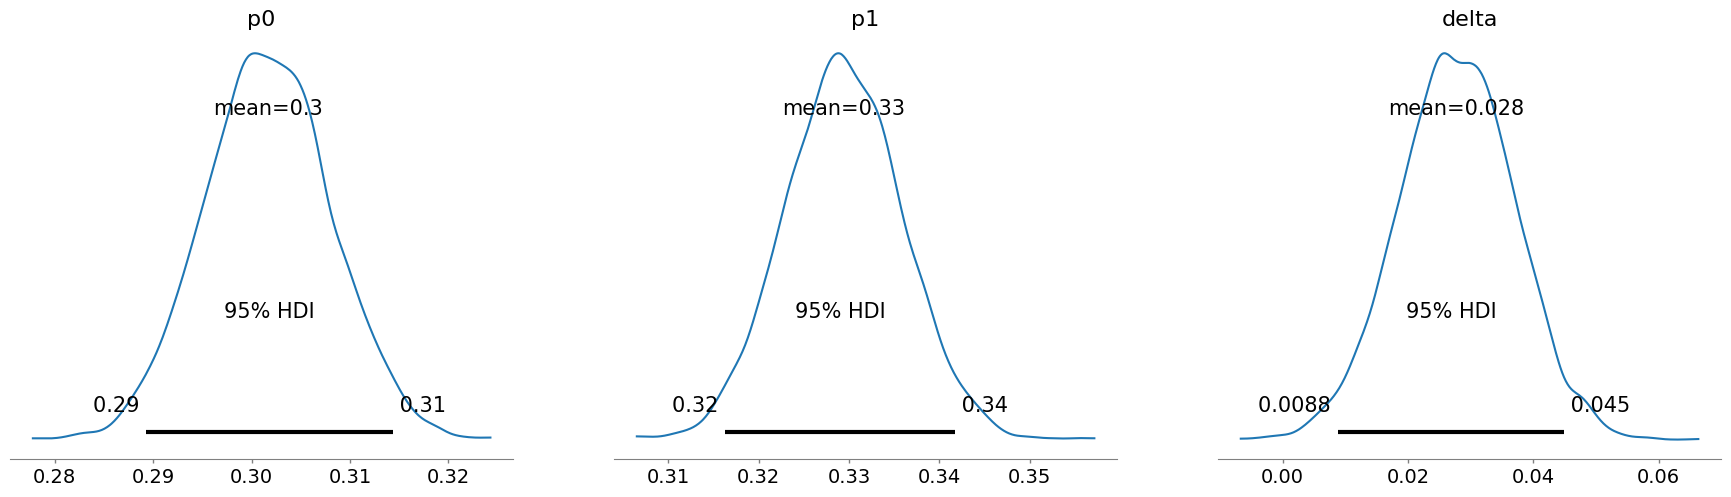

In [10]:
y0 = df_fake[df_fake['target'] == 0]['conversion'].values
y1 = df_fake[df_fake['target'] == 1]['conversion'].values

delta_samples, trace = bayesian_ab_test_binary(
    y0=y0,
    y1=y1,
    draws=2000,
    tune=1000,
    chains=4,
    target_accept=0.9,
)

P(delta > 0.035) = 0.2172


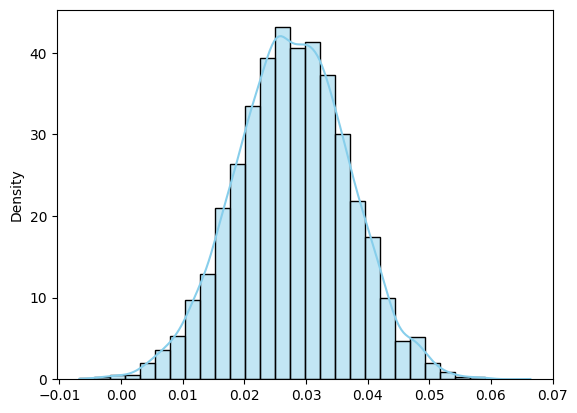

In [11]:
prob_delta_gt_0 = (delta_samples > 0.035).mean()
print(f"P(delta > 0.035) = {prob_delta_gt_0:.4f}")

sns.histplot(delta_samples, kde=True, stat="density", bins=30, color="skyblue", edgecolor="black");

Вірогідність мати значення більше (в даному випадку 34% шанс мати значення більше за 0.035) є площою всіх барів що йдуть праворуч від обраного значення

In [12]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.302,0.006,0.290,0.314,0.0,0.0,7681.0,5292.0,1.0
p1,0.329,0.007,0.317,0.342,0.0,0.0,7524.0,5571.0,1.0
delta,0.028,0.009,0.010,0.044,0.0,0.0,7136.0,5013.0,1.0
